# 뷰티 + 음식 sns 언급 빈도에 따른 지역 소비금액 성장/하락률

In [59]:
import numpy as np
import pandas as pd
import glob

In [60]:

# 푸드 데이터 로드
path_food = r"C:\GIT\data\EC_SNS_KFOOD_ATTRACTION_DATA_*.csv"
files_food = glob.glob(path_food)
df_food = [pd.read_csv(f, encoding="utf-8") for f in files_food]
sns_kfood = pd.concat(df_food, ignore_index=True)

# 뷰티 데이터 로드
path_beauty = r"C:\GIT\data\EC_SNS_KBEAUTY_ATTRACTION_DATA_*.csv"
files_beauty = glob.glob(path_beauty)
df_beauty = [pd.read_csv(f, encoding="utf-8") for f in files_beauty]
sns_beauty = pd.concat(df_beauty, ignore_index=True)

# 데이터 병합
full_df = pd.concat([sns_kfood, sns_beauty], ignore_index=True)

In [61]:
# 채널 이름이 체널 전체인 것들만 추출 후 0으로 초기화
full_df = full_df[full_df['CHNNEL_NM'] == '채널전체'].copy()
full_df = full_df.fillna(0)

# Unnamed 컬럼 제거
full_df = full_df.loc[:, ~full_df.columns.astype(str).str.startswith("Unnamed")]

# 이상 지역 제거
full_df = full_df[full_df["SIGNGU_NM"].astype(str) != "0"]
full_df = full_df[full_df["SIGNGU_NM"].astype(str) != "KR"]
full_df = full_df[full_df["SIGNGU_NM"].astype(str) != "영동대로"]   # 도로는 3개의 구를 끼고 있어서 제거

# 사용할 컬럼 추출
use_cols = ['BASE_YM', 'CTPRVN_NM', 'SIGNGU_NM',
            'BASE_YEAR_ACCMLT_FQ_CO',       # 기준년도누적빈도수
            'TURSM_CSTMR_CO',               # 관광객 수
            'TURSM_SPND_PRICE',             # 관광소비금액 (총합)
            'AVRG_SCORE_VALUE',             # 평점값
            'REVIEW_CO',                    # 리뷰수
        ]
df_sub = full_df[use_cols].copy()

# 데이터 형 변환
df_sub['BASE_YM'] = pd.to_datetime(df_sub['BASE_YM'], format='%Y%m')
df_sub = df_sub.fillna(0)

ctprvn_map = {
    '인천': '인천광역시', 
    '서울':'서울특별시',
    '서울시': '서울특별시',
    '강원특별자치도': '강원도',
    '고양시':'경기도',
    '남양주시':'경기도',
    '부산':'부산광역시',
    '성남시':'경기도',
    '수원시': '경기도',
    '인천':'인천광역시',
    '전북특별자치도':'전라북도',
    '천안시':'강원도',
    '춘천시':'강원도'
}

signgu_map = {
    '고양시 일산동구': '고양시',
    '고양시 일산서구' : '고양시',
    '공덕역': '마포구',
    '까치산역':'강서구 ',
    '남산면':'춘천시',
    '남창동': '중구',
    '대화역':'고양시',
    '망원역' : '마포구',
    '성남시 분당구' : '성남시',
    '성북동성당' : '성북구',
    '성수1가제2동' : '성동구',
    '성신여대입구역' : '성북구',
    '수원시 영통구' : '수원시',
    '수원시 팔달구' : '수원시',
    '예지동' : '종로구',
    '용인시 기흥구' : '용인시',
    '용인시 처인구' : '용인시',
    '잠실본동' : '송파구',
    '전주시 완산구' : '전주시',
    '정자역' : '성남시',
    '천안시 동남구' :'천안시',
    '청주시 상당구' : '청주시',
    '청주시 청원구' : '청주시',
    '평내호평역' : '남양주시',
    '포항시 남구' : '포항시',
    '화양동' : '광진구'
}

df_sub['CTPRVN_NM'] = df_sub['CTPRVN_NM'].replace(ctprvn_map)
df_sub['SIGNGU_NM'] = df_sub['SIGNGU_NM'].replace(signgu_map)

# 시군구 중간 확인용
# items = sorted(df_sub['SIGNGU_NM'].unique().tolist())
# for i, item in enumerate(items):
#     print(f"{item:<12}", end="")
#     if (i + 1) % 6 == 0:       
#         print()

num_cols = [
    'TURSM_CSTMR_CO',
    'TURSM_SPND_PRICE',
    'AVRG_SCORE_VALUE',
    'REVIEW_CO',
    'BASE_YEAR_ACCMLT_FQ_CO'
]

for c in num_cols:
    df_sub[c] = pd.to_numeric(df_sub[c], errors='coerce')



In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 년 월 시 군구로 집계
final_df = df_sub.groupby(['BASE_YM', 'CTPRVN_NM', 'SIGNGU_NM']).agg({
    'TURSM_SPND_PRICE': 'mean',          # 관광소비금액
    'TURSM_CSTMR_CO': 'mean',            # 관광고객수
    'AVRG_SCORE_VALUE': 'mean',          # 평점값
    'BASE_YEAR_ACCMLT_FQ_CO': 'sum',     # 기준년월 sns 언급 빈도수
    'REVIEW_CO':'sum'                    # 리뷰수
}).reset_index()


# 정렬
final_df = final_df.sort_values(["CTPRVN_NM", "SIGNGU_NM", "BASE_YM"]).reset_index(drop=True)

In [63]:
# final_df.to_csv('02101236.csv')

In [64]:
# 시군구별 그룹
group_cols = ["CTPRVN_NM", "SIGNGU_NM"]
base_features = ['TURSM_SPND_PRICE', 'TURSM_CSTMR_CO', 'AVRG_SCORE_VALUE', 'BASE_YEAR_ACCMLT_FQ_CO', 'REVIEW_CO']

# 과거 값 가져오기
for col in base_features:
    final_df[f"{col}_L1"] = final_df.groupby(group_cols)[col].shift(1) # 1개월 전
    final_df[f"{col}_L2"] = final_df.groupby(group_cols)[col].shift(2) # 2개월 전

# 전월 대비 성장률 구하기
for col in base_features:
    prev = final_df.groupby(group_cols)[col].shift(1)
    final_df[f"{col}_MOM_RATE"] = (final_df[col] - prev) / prev.replace(0, np.nan)

# 최근 3개월 추세(롤링)
for col in base_features:
    final_df[f"{col}_ROLL3"] = final_df.groupby(group_cols)[col].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

# 무한대/결측 정리
final_df = final_df.replace([np.inf, -np.inf], np.nan)

# 다음달 상승/하락
final_df["CSTMR_NEXT"] = final_df.groupby(group_cols)["TURSM_SPND_PRICE"].shift(-1)

# 마지막 달은 학습에서 제외
final_df["NEXT_GROWTH_LABEL"] = np.where(
    final_df["CSTMR_NEXT"].isna(),
    np.nan,
    (final_df["CSTMR_NEXT"] > final_df["TURSM_SPND_PRICE"]).astype(int)
)

In [65]:
fc = final_df.columns
fc = fc.drop(['BASE_YM', 'CTPRVN_NM', 'SIGNGU_NM', 'CSTMR_NEXT', 'NEXT_GROWTH_LABEL'])
fc.to_list()
final_df[fc]

,TURSM_SPND_PRICE,TURSM_CSTMR_CO,AVRG_SCORE_VALUE,BASE_YEAR_ACCMLT_FQ_CO,REVIEW_CO,TURSM_SPND_PRICE_L1,TURSM_SPND_PRICE_L2,TURSM_CSTMR_CO_L1,TURSM_CSTMR_CO_L2,AVRG_SCORE_VALUE_L1,...,TURSM_SPND_PRICE_MOM_RATE,TURSM_CSTMR_CO_MOM_RATE,AVRG_SCORE_VALUE_MOM_RATE,BASE_YEAR_ACCMLT_FQ_CO_MOM_RATE,REVIEW_CO_MOM_RATE,TURSM_SPND_PRICE_ROLL3,TURSM_CSTMR_CO_ROLL3,AVRG_SCORE_VALUE_ROLL3,BASE_YEAR_ACCMLT_FQ_CO_ROLL3,REVIEW_CO_ROLL3
0,2.630604e+07,1.506432e+06,4.400000,13.0,74576.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.490574e+07,2.303350e+06,3.800000,10.0,123.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.508489e+07,2.561433e+06,3.800000,25.0,123.0,1.490574e+07,NaN,2303350.0,NaN,3.800000,...,0.012019,0.112047,0.000000,1.500000,0.000000,1.490574e+07,2.303350e+06,3.800000,10.000000,123.000000
3,1.497236e+07,2.291044e+06,3.800000,25.0,127.0,1.508489e+07,14905735.0,2561433.0,2303350.0,3.800000,...,-0.007459,-0.105562,0.000000,0.000000,0.032520,1.499531e+07,2.432392e+06,3.800000,17.500000,123.000000
4,1.996162e+07,3.197509e+06,3.800000,25.0,128.0,1.497236e+07,15084889.0,2291044.0,2561433.0,3.800000,...,0.333231,0.395656,0.000000,0.000000,0.007874,1.498766e+07,2.385276e+06,3.800000,20.000000,124.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,5.989339e+07,2.657098e+06,4.400000,4.0,2750.0,3.987310e+05,11545845.0,2489592.0,2439528.0,4.400000,...,149.210019,0.067283,0.000000,0.000000,0.008065,2.242419e+07,5.702546e+06,4.400000,6.333333,2703.000000
784,5.969836e+07,2.734144e+06,4.400000,4.0,2765.0,5.989339e+07,398731.0,2657098.0,2489592.0,4.400000,...,-0.003256,0.028996,0.000000,0.000000,0.005455,2.394599e+07,2.528739e+06,4.400000,3.666667,2726.666667
785,5.996623e+07,2.938790e+06,4.450000,6.0,6163.0,5.969836e+07,59893391.0,2734144.0,2657098.0,4.400000,...,0.004487,0.074848,0.011364,0.500000,1.228933,3.999683e+07,2.626945e+06,4.400000,4.000000,2747.666667
786,5.757273e+07,2.728054e+06,4.433333,7.0,9000.0,5.996623e+07,59698360.0,2938790.5,2734144.0,4.450000,...,-0.039914,-0.071709,-0.003745,0.166667,0.460328,5.985266e+07,2.776678e+06,4.416667,4.666667,3892.666667


In [66]:

df_all = final_df.copy()
feature_cols = final_df.columns.drop(['BASE_YM', 'CTPRVN_NM', 'SIGNGU_NM', 'CSTMR_NEXT', 'NEXT_GROWTH_LABEL']).tolist()

train_df = df_all.dropna(subset=feature_cols + ["NEXT_GROWTH_LABEL"]).copy()
pred_df  = df_all[df_all["NEXT_GROWTH_LABEL"].isna()].dropna(subset=feature_cols).copy()

X_train, X_test, y_train, y_test = train_test_split(
    train_df[feature_cols],
    train_df["NEXT_GROWTH_LABEL"],
    test_size=0.2,
    random_state=0,
    stratify=train_df["NEXT_GROWTH_LABEL"]
)

# RandomForest로 확률 예측
rf = RandomForestClassifier(
    n_estimators=1200,
    min_samples_leaf=2,
    class_weight="balanced",    # 라벨이 불균형(예: 성장=1이 적음)일 때 소수 클래스에 더 큰 가중치를 줘서 학습이 그쪽을 무시하지 않게 함.
    random_state=42,
    n_jobs=-1                   # cpu
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test) # 0/1 예측
# 예측
pred_df["proba_up"] = rf.predict_proba(pred_df[feature_cols])[:, 1]
pred_df["proba_down"] = 1 - pred_df["proba_up"]
pred_df["pred_label"] = (pred_df["proba_up"] >= 0.5).astype(int)

# pred_df.sort_values("proba_up", ascending=False)

# top10 = pred_df.sort_values("proba_up", ascending=False).head(10)

for _, r in pred_df.iterrows():
    label = 1 if r["proba_up"] >= 0.5 else 0
    print(f"지역 : {r['CTPRVN_NM']} {r['SIGNGU_NM']}")
    print(f"예측 결과: 인기 {'상승' if label==1 else '하락'}")
    print(f"상승 확률: {r['proba_up']:.2f}")
    print(f"하락 확률: {r['proba_down']:.2f}")
    print("-"*40)


지역 : 강원도 강릉시
예측 결과: 인기 하락
상승 확률: 0.21
하락 확률: 0.79
----------------------------------------
지역 : 강원도 속초시
예측 결과: 인기 상승
상승 확률: 0.51
하락 확률: 0.49
----------------------------------------
지역 : 강원도 춘천시
예측 결과: 인기 상승
상승 확률: 0.75
하락 확률: 0.25
----------------------------------------
지역 : 강원도 홍천군
예측 결과: 인기 하락
상승 확률: 0.32
하락 확률: 0.68
----------------------------------------
지역 : 경기도 가평군
예측 결과: 인기 하락
상승 확률: 0.31
하락 확률: 0.69
----------------------------------------
지역 : 경기도 고양시
예측 결과: 인기 하락
상승 확률: 0.45
하락 확률: 0.55
----------------------------------------
지역 : 경기도 과천시
예측 결과: 인기 하락
상승 확률: 0.42
하락 확률: 0.58
----------------------------------------
지역 : 경기도 구리시
예측 결과: 인기 상승
상승 확률: 0.69
하락 확률: 0.31
----------------------------------------
지역 : 경기도 성남시
예측 결과: 인기 상승
상승 확률: 0.69
하락 확률: 0.31
----------------------------------------
지역 : 경기도 수원시
예측 결과: 인기 상승
상승 확률: 0.81
하락 확률: 0.19
----------------------------------------
지역 : 경기도 시흥시
예측 결과: 인기 상승
상승 확률: 0.59
하락 확률: 0.41
----------------------------------------

---

In [67]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.7727272727272727
[[35 10]
 [10 33]]
              precision    recall  f1-score   support

         0.0     0.7778    0.7778    0.7778        45
         1.0     0.7674    0.7674    0.7674        43

    accuracy                         0.7727        88
   macro avg     0.7726    0.7726    0.7726        88
weighted avg     0.7727    0.7727    0.7727        88



In [68]:
fi = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
fi_df = fi.reset_index()
fi_df.columns = ["feature", "importance"]
fi_df.head(15)

,feature,importance
0,TURSM_SPND_PRICE_MOM_RATE,0.159552
1,BASE_YEAR_ACCMLT_FQ_CO_MOM_RATE,0.143206
2,TURSM_CSTMR_CO_MOM_RATE,0.112987
3,TURSM_SPND_PRICE_L2,0.054392
4,REVIEW_CO_MOM_RATE,0.047983
5,TURSM_SPND_PRICE_ROLL3,0.044643
6,TURSM_SPND_PRICE_L1,0.038638
7,TURSM_SPND_PRICE,0.038147
8,TURSM_CSTMR_CO_L1,0.033879
9,TURSM_CSTMR_CO_L2,0.030135


In [69]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()

plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False 

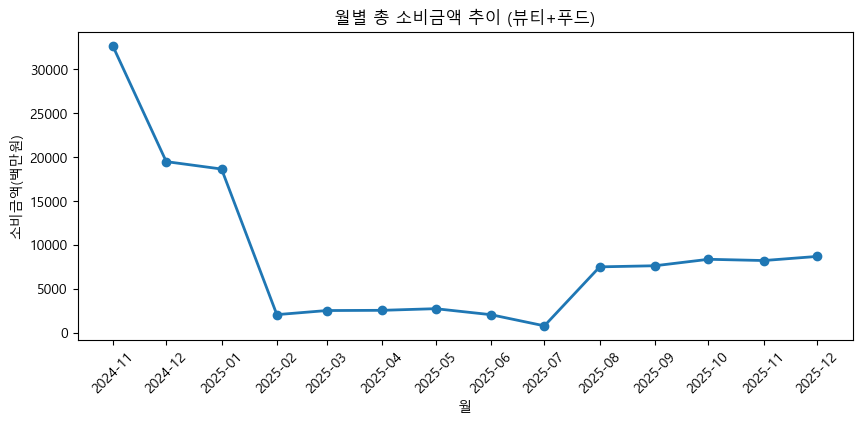

In [70]:
import pandas as pd

monthly = final_df.copy()
monthly["BASE_YM"] = pd.to_datetime(monthly["BASE_YM"])

total_month = (monthly.groupby("BASE_YM")["TURSM_SPND_PRICE"]
               .sum()
               .reset_index()
               .sort_values("BASE_YM"))


total_month["TURSM_SPND_PRICE"] = total_month["TURSM_SPND_PRICE"] / 1_000_000

plt.figure(figsize=(10, 4))
plt.plot(total_month["BASE_YM"], total_month["TURSM_SPND_PRICE"], marker="o", linewidth=2)

plt.title("월별 총 소비금액 추이 (뷰티+푸드)")
plt.xlabel("월")
plt.ylabel("소비금액(백만원)")
plt.xticks(total_month["BASE_YM"], total_month["BASE_YM"].dt.strftime("%Y-%m"), rotation=45)
plt.show()


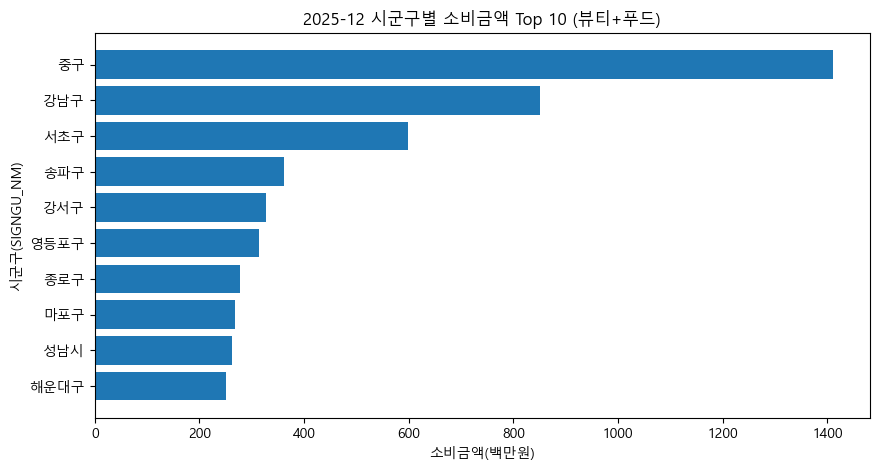

In [71]:
monthly = final_df.copy()
monthly["BASE_YM"] = pd.to_datetime(monthly["BASE_YM"])

latest_month = monthly["BASE_YM"].max()

latest_top = (monthly[monthly["BASE_YM"] == latest_month]
              .groupby("SIGNGU_NM")["TURSM_SPND_PRICE"]
              .sum()
              .sort_values(ascending=False)
              .head(10))

plt.figure(figsize=(10,5))
plt.barh(latest_top.index[::-1], (latest_top.values[::-1] / 1_000_000))  # ✅ 값도 백만원
plt.title(f"{latest_month.strftime('%Y-%m')} 시군구별 소비금액 Top 10 (뷰티+푸드)")
plt.xlabel("소비금액(백만원)")
plt.ylabel("시군구(SIGNGU_NM)")
plt.ticklabel_format(axis="x", style="plain", useOffset=False)
plt.show()


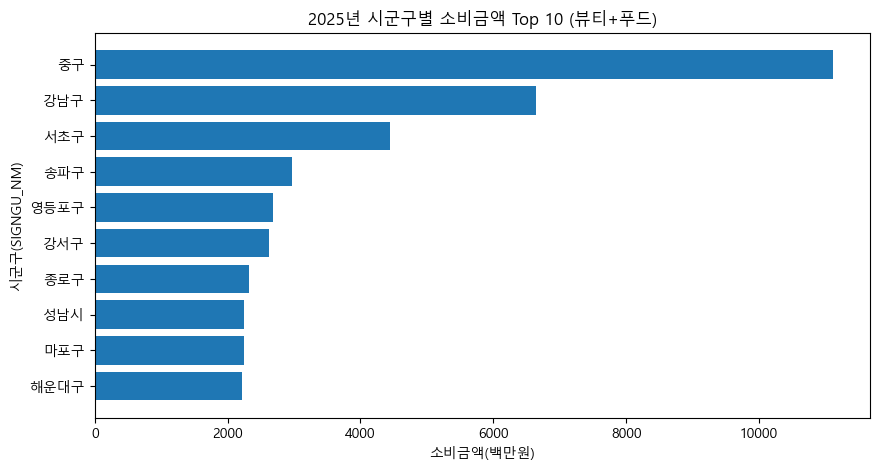

In [72]:
monthly = final_df.copy()
monthly["BASE_YM"] = pd.to_datetime(monthly["BASE_YM"])

year = 2025

latest_top = (monthly[monthly["BASE_YM"].dt.year == year]
              .groupby("SIGNGU_NM")["TURSM_SPND_PRICE"]
              .sum()
              .sort_values(ascending=False)
              .head(10))

plt.figure(figsize=(10,5))
plt.barh(latest_top.index[::-1], (latest_top.values[::-1] / 1_000_000))  # ✅ 값도 백만원
plt.title(f"{year}년 시군구별 소비금액 Top 10 (뷰티+푸드)")
plt.xlabel("소비금액(백만원)")
plt.ylabel("시군구(SIGNGU_NM)")
plt.ticklabel_format(axis="x", style="plain", useOffset=False)
plt.show()


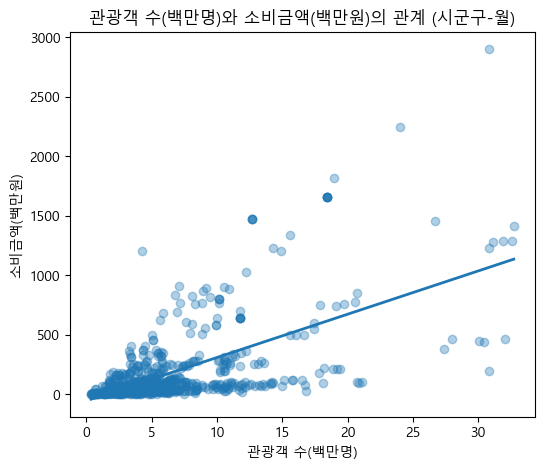

In [73]:
temp = monthly[["BASE_YM","SIGNGU_NM","TURSM_CSTMR_CO","TURSM_SPND_PRICE"]].copy()
temp["BASE_YM"] = pd.to_datetime(temp["BASE_YM"], errors="coerce")

temp["TURSM_CSTMR_CO"] = pd.to_numeric(temp["TURSM_CSTMR_CO"], errors="coerce").fillna(0)
temp["TURSM_SPND_PRICE"] = pd.to_numeric(temp["TURSM_SPND_PRICE"], errors="coerce").fillna(0)

g = (temp.dropna(subset=["BASE_YM"])
        .groupby(["BASE_YM","SIGNGU_NM"])
        .agg({"TURSM_CSTMR_CO":"sum","TURSM_SPND_PRICE":"sum"})
        .reset_index())

x = (g["TURSM_CSTMR_CO"] / 1_000_000).to_numpy() 
y = (g["TURSM_SPND_PRICE"] / 1_000_000).to_numpy() 

plt.figure(figsize=(6,5))
plt.scatter(x, y, alpha=0.35)

m = (x > 0) & (y != 0)
if m.sum() >= 2:
    a, b = np.polyfit(x[m], y[m], 1)
    xx = np.linspace(x[m].min(), x[m].max(), 200)
    plt.plot(xx, a*xx + b, linewidth=2)

plt.title("관광객 수(백만명)와 소비금액(백만원)의 관계 (시군구-월)")
plt.xlabel("관광객 수(백만명)")
plt.ylabel("소비금액(백만원)")
plt.ticklabel_format(axis="x", style="plain", useOffset=False)
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.show()


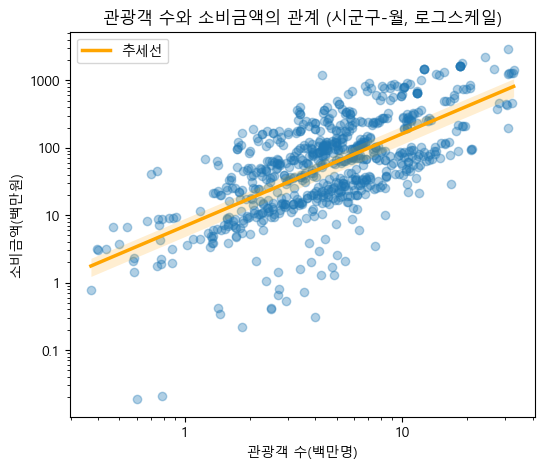

In [74]:
from matplotlib.ticker import LogLocator, FuncFormatter
import numpy as np
import matplotlib.pyplot as plt

x = g["TURSM_CSTMR_CO"].to_numpy() / 1_000_000      # 백만명
y = g["TURSM_SPND_PRICE"].to_numpy() / 1_000_000    # 백만원

m = (x > 0) & (y > 0)
x = x[m]
y = y[m]

plt.figure(figsize=(6,5))
plt.scatter(x, y, alpha=0.35)

plt.xscale("log")
plt.yscale("log")

plt.gca().xaxis.set_major_locator(LogLocator(base=10))
plt.gca().yaxis.set_major_locator(LogLocator(base=10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:g}"))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:g}"))

# 추세선(로그축용) + 형광 밴드
if x.size >= 2:
    lx = np.log10(x)
    ly = np.log10(y)
    a, b = np.polyfit(lx, ly, 1)
    xx = np.linspace(lx.min(), lx.max(), 200)

    y_line = 10**(a*xx + b)

    line_color = "orange"
    plt.plot(10**xx, y_line, color=line_color, linewidth=2.5, label="추세선")

    band_ratio = 0.30
    plt.fill_between(
        10**xx,
        y_line * (1 - band_ratio),
        y_line * (1 + band_ratio),
        color=line_color,
        alpha=0.18,
        linewidth=0
    )

plt.title("관광객 수와 소비금액의 관계 (시군구-월, 로그스케일)")
plt.xlabel("관광객 수(백만명)")
plt.ylabel("소비금액(백만원)")
plt.legend()
plt.show()


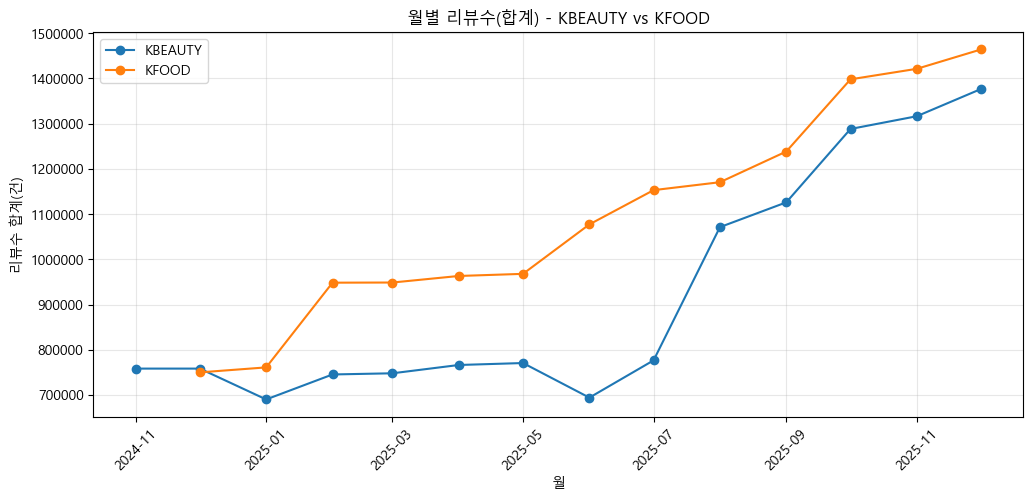

In [75]:
df_food = sns_kfood.copy()
df_food["CATEGORY"] = "KFOOD"

df_beauty = sns_beauty.copy()
df_beauty["CATEGORY"] = "KBEAUTY"

df = pd.concat([df_food, df_beauty], ignore_index=True)
df = df[df["CHNNEL_NM"] == "채널전체"].copy()

# 날짜(월)
df["BASE_YM"] = df["BASE_YM"].astype(str).str.strip()
df["MONTH"] = pd.to_datetime(df["BASE_YM"], format="%Y%m", errors="coerce")

# 리뷰수 숫자형 변환
df["REVIEW_CO"] = pd.to_numeric(df["REVIEW_CO"], errors="coerce").fillna(0)

# 뷰티/푸드
df2 = df[df["CATEGORY"].isin(["KBEAUTY", "KFOOD"])].copy()

# 월별 + 카테고리별 리뷰수 합계
monthly = (
    df2.groupby(["MONTH", "CATEGORY"])["REVIEW_CO"]
       .sum()
       .reset_index()
       .sort_values("MONTH")
)

plt.figure(figsize=(12, 5))

for category_name, group_df in monthly.groupby("CATEGORY"):
    plt.plot(group_df["MONTH"], group_df["REVIEW_CO"], marker="o", label=category_name)

plt.title("월별 리뷰수(합계) - KBEAUTY vs KFOOD")
plt.xlabel("월")
plt.ylabel("리뷰수 합계(건)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


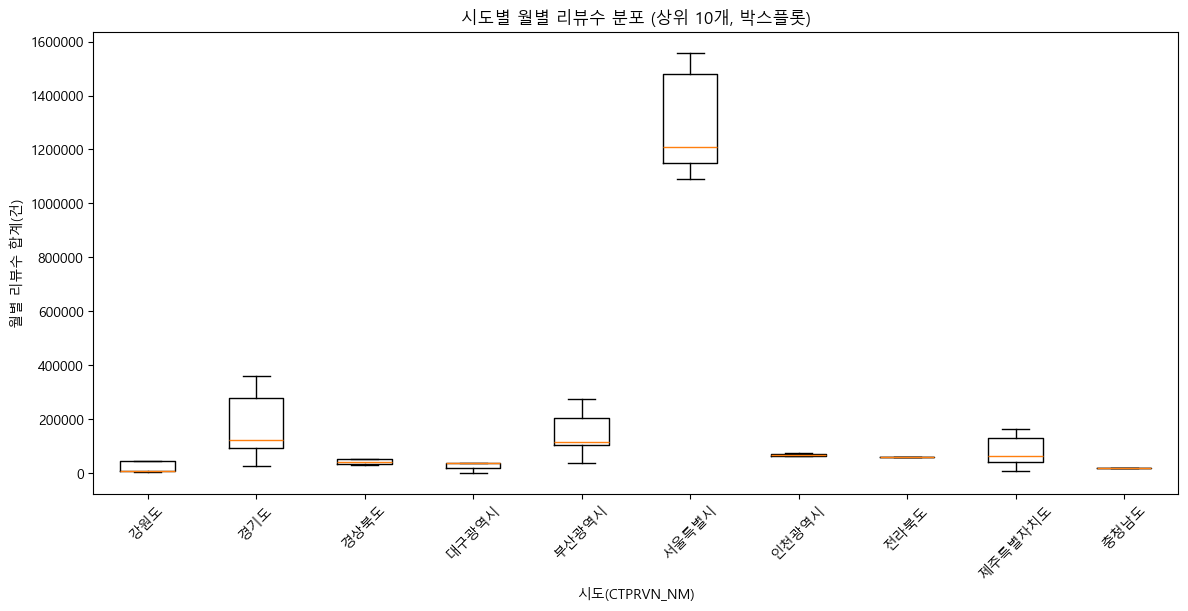

In [76]:
rm = (final_df
      .groupby(["BASE_YM", "CTPRVN_NM"], as_index=False)["REVIEW_CO"]
      .sum())

top10 = (rm.groupby("CTPRVN_NM")["REVIEW_CO"]
           .sum()
           .sort_values(ascending=False)
           .head(10)
           .index)

rm_top = rm[rm["CTPRVN_NM"].isin(top10)]
grp = rm_top.groupby("CTPRVN_NM")["REVIEW_CO"]

plt.figure(figsize=(14,6))
plt.boxplot([v.to_numpy() for _, v in grp], tick_labels=[k for k, _ in grp], showfliers=False)

plt.title("시도별 월별 리뷰수 분포 (상위 10개, 박스플롯)")
plt.xlabel("시도(CTPRVN_NM)")
plt.ylabel("월별 리뷰수 합계(건)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.xticks(rotation=45)
plt.show()


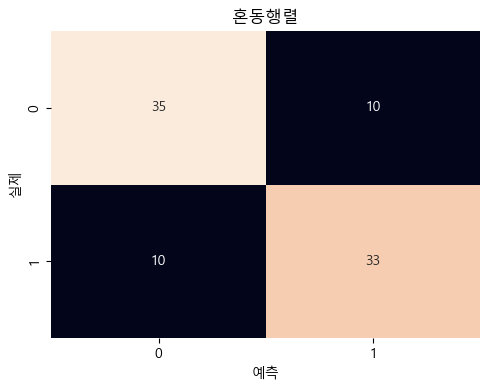

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_proba_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)


assert "y_test" in globals() and "y_pred_test" in globals()

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("혼동행렬")
plt.xlabel("예측")
plt.ylabel("실제")
plt.tight_layout()
plt.show()


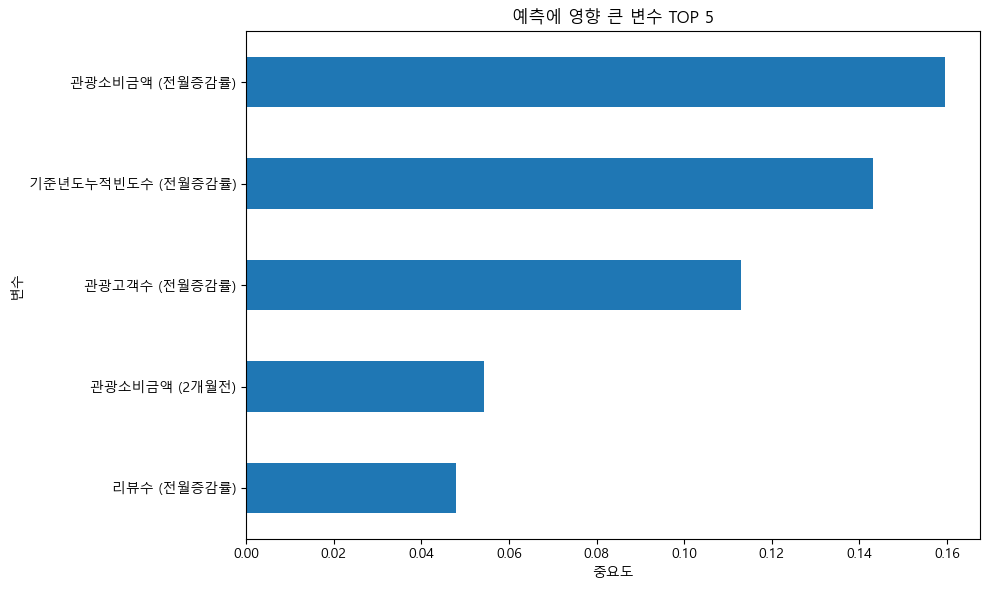

In [78]:
import re
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

TOP_N = 5

base_map = {
    "BASE_YM_FQ_CO": "기준년월빈도수",
    "BASE_YEAR_ACCMLT_FQ_CO": "기준년도누적빈도수",
    "REVIEW_CO": "리뷰수",
    "AVRG_SCORE_VALUE": "평점값",
    "CTPRVN_NM": "시도명",
    "SIGNGU_NM": "시군구명",
    "TURSM_CSTMR_CO": "관광고객수",
    "TURSM_SPND_PRICE": "관광소비금액",
    "NATIVE_TURSM_SPND_PRICE": "내국인관광소비금액",
    "FRNR_TURSM_SPND_PRICE": "외국인관광소비금액",
}

suffix_map = {
    "MOM_RATE": " (전월증감률)",
    "DIFF_VALUE": " (전월증감)",
    "ROLL3": " (3개월이동평균)",
    "L1": " (1개월전)",
    "L2": " (2개월전)",
    "L3": " (3개월전)",
}

def to_kr(name: str) -> str:
    # num__/cat__ 같은 접두사 제거
    if "__" in name:
        name = name.split("__", 1)[1]

    # base_key_tail 형태 처리
    for key, kr in base_map.items():
        prefix = key + "_"
        if name.startswith(prefix):
            tail = name[len(prefix):]
            # 파생 접미사면 한글화
            if tail in suffix_map:
                return kr + suffix_map[tail]
            # 그 외
            return f"{kr}={tail}"

    # 끝에 _L4, _ROLL12 같은 패턴(필요할 때만)
    m = re.search(r"_(L\d+|ROLL\d+)$", name)
    if m:
        base = name[: -len(m.group(0))]
        tail = m.group(1)
        if tail.startswith("L"):
            return f"{base_map.get(base, base)} ({tail[1:]}개월전)"
        if tail.startswith("ROLL"):
            return f"{base_map.get(base, base)} ({tail[4:]}개월이동평균)"

    return base_map.get(name, name)

fi = (pd.Series(rf.feature_importances_, index=feature_cols)
      .sort_values(ascending=False)
      .head(TOP_N))

fi.index = [to_kr(c) for c in fi.index]

plt.figure(figsize=(10, 6))
fi[::-1].plot(kind="barh")
plt.title(f"예측에 영향 큰 변수 TOP {TOP_N}")
plt.xlabel("중요도")
plt.ylabel("변수")
plt.tight_layout()
plt.show()


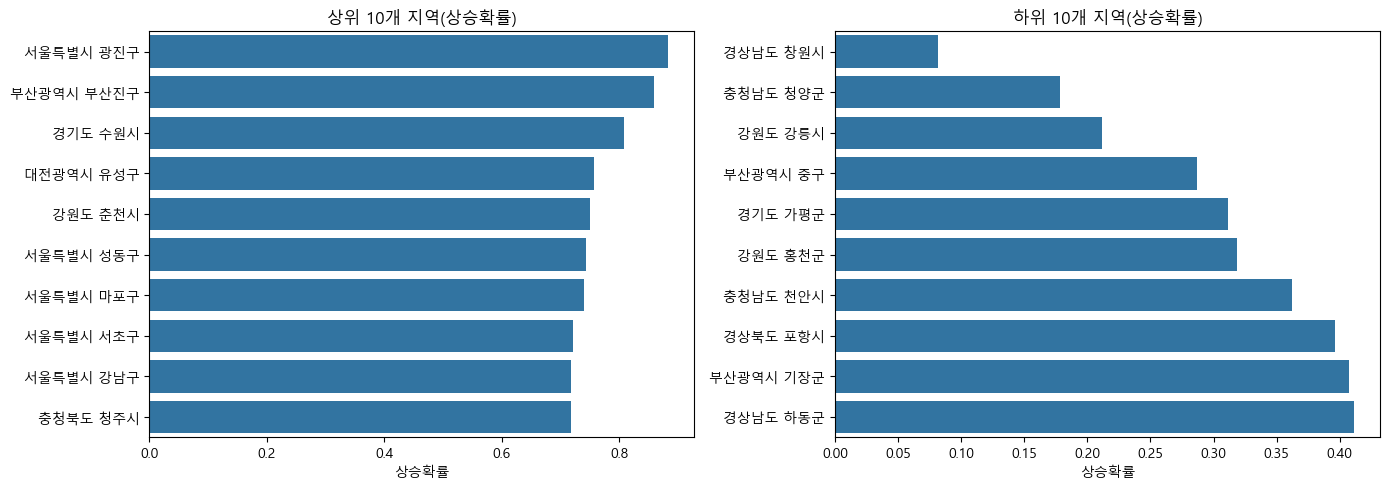

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# 필수 변수 없으면 바로 중단
assert pred_df is not None and len(pred_df) > 0
assert "rf" in globals() and "feature_cols" in globals()

# proba_up 없으면 생성
if "proba_up" not in pred_df.columns:
    pred_df["proba_up"] = rf.predict_proba(pred_df[feature_cols])[:, 1]

# REGION 라벨 생성
if "REGION" not in pred_df.columns:
    pred_df["REGION"] = pred_df["CTPRVN_NM"].astype(str) + " " + pred_df["SIGNGU_NM"].astype(str)

# 상위10 / 하위10
topk = pred_df.sort_values("proba_up", ascending=False).head(10)
botk = pred_df.sort_values("proba_up", ascending=True).head(10)

plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
sns.barplot(data=topk, y="REGION", x="proba_up", ax=ax1)
ax1.set_title("상위 10개 지역(상승확률)")
ax1.set_xlabel("상승확률")
ax1.set_ylabel("")

ax2 = plt.subplot(1,2,2)
sns.barplot(data=botk, y="REGION", x="proba_up", ax=ax2)
ax2.set_title("하위 10개 지역(상승확률)")
ax2.set_xlabel("상승확률")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()